This jupyter notebook can be used to visualize how recyling trends are correlated with other features like socio-economic features of NYC. 

We will show correlation plots and to generate and see the efficacy of a multivariate regression model. We will look at the OLC stats to quantify how effective the correlations in predicting the target variable like diversion or capture rate.

Lets start with loading the packages needed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [2]:
data_demo=pd.read_csv("datas/DemographicsTable.csv")
df=data_demo=pd.read_csv("datas/DemographicsTable.csv")
data_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   District                                      59 non-null     object 
 1   Organic Tons                                  59 non-null     float64
 2   MGP tons                                      59 non-null     float64
 3   Paper Tons                                    59 non-null     float64
 4   Refuse Tons                                   59 non-null     float64
 5   Diversion rate (%)                            59 non-null     float64
 6   Total Population                              59 non-null     int64  
 7   Median Age                                    59 non-null     float64
 8   Population/acre                               59 non-null     float64
 9   Hispanic                                      59 non-null     float

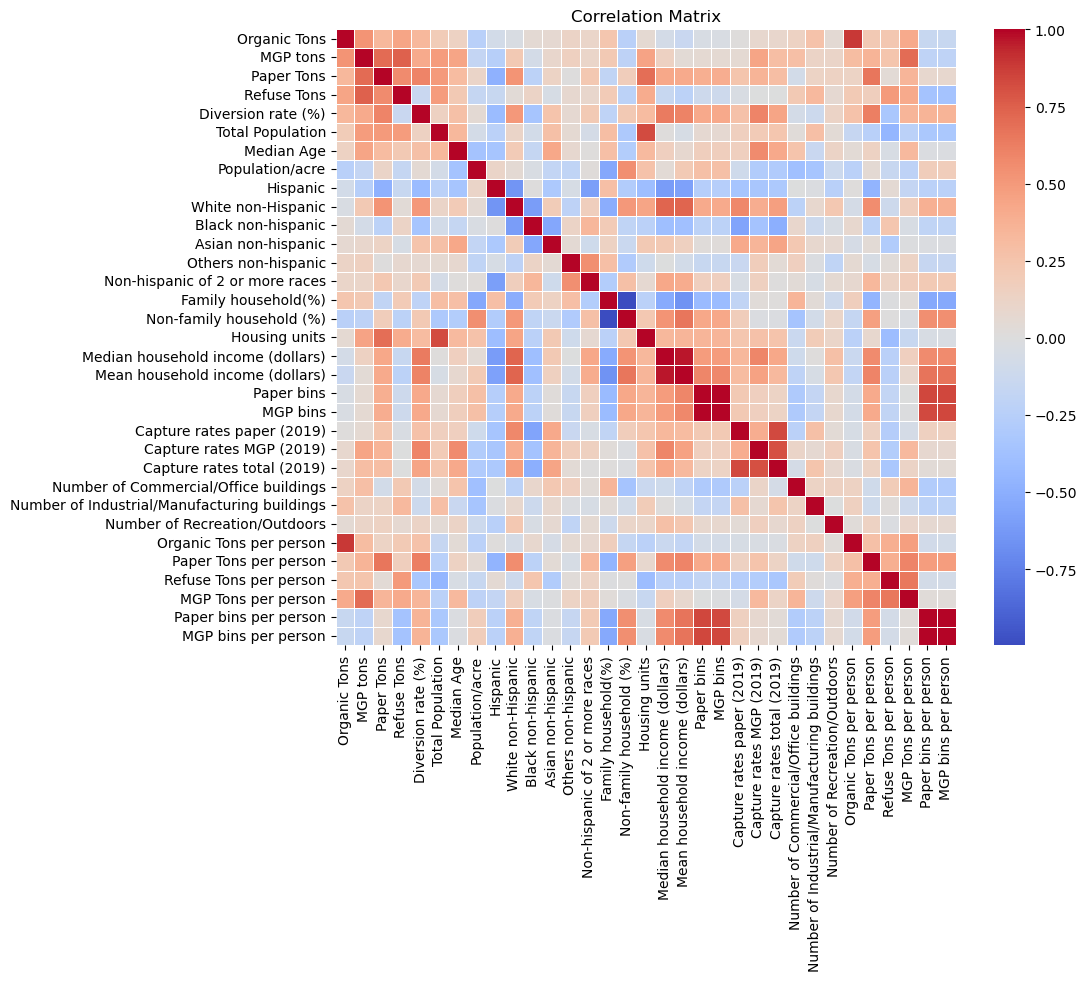

In [67]:
numeric_data = data_demo.select_dtypes(include='number')  # Select only numeric columns
corr_matrix = numeric_data.corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig("corr_mat.png",dpi=300,bbox_inches="tight")
plt.show()

Based on the above correlaiton matrix lets pull out interesting correlations to look at. For this we will ask the code to pull out feature pairs that have correlation magnitude (positive or negative) above 0.5

In [25]:
# Function to extract pairs with correlation magnitude > threshold
def get_high_correlation_pairs(corr_matrix, threshold=0.5):
    # Get the variable names
    variables = corr_matrix.columns.tolist()
    
    # Initialize a list to store high correlation pairs
    high_corr_pairs = []
    
    # Iterate through the upper triangle of the correlation matrix
    for i in range(len(variables)):
        for j in range(i+1, len(variables)):  # Start from i+1 to avoid diagonal and lower triangle
            # Get the correlation value
            corr_value = corr_matrix.iloc[i, j]
            
            # Check if the absolute correlation is greater than the threshold
            if abs(corr_value) > threshold:
                # Add the pair to the list with correlation value
                high_corr_pairs.append({
                    'Variable1': variables[i],
                    'Variable2': variables[j],
                    'Correlation': corr_value
                })
    
    # Convert the list to a DataFrame
    high_corr_df = pd.DataFrame(high_corr_pairs)
    
    # Sort by absolute correlation value in descending order
    if not high_corr_df.empty:
        high_corr_df['Abs_Correlation'] = high_corr_df['Correlation'].abs()
        high_corr_df = high_corr_df.sort_values('Abs_Correlation', ascending=False)
        high_corr_df = high_corr_df.drop('Abs_Correlation', axis=1)
    
    return high_corr_df

# Extract pairs with correlation magnitude > 0.6
high_corr_pairs = get_high_correlation_pairs(corr_matrix, 0.6)

high_corr_pairs_cleaned=high_corr_pairs.drop([29,21,15,18,0,25,7,22,24,14,3,5])
high_corr_pairs

,Variable1,Variable2,Correlation
21,Paper bins,MGP bins,0.999958
29,Paper bins per person,MGP bins per person,0.999953
15,Family household(%),Non-family household (%),-0.997129
18,Median household income (dollars),Mean household income (dollars),0.965985
0,Organic Tons,Organic Tons per person,0.889403
23,Paper bins,MGP bins per person,0.840627
25,MGP bins,MGP bins per person,0.837610
22,Paper bins,Paper bins per person,0.837503
24,MGP bins,Paper bins per person,0.834413
26,Capture rates paper (2019),Capture rates total (2019),0.832626


Naturally some of these are derivative of each other example Paper Tons and              Paper Tons per person so we will ignore those. 

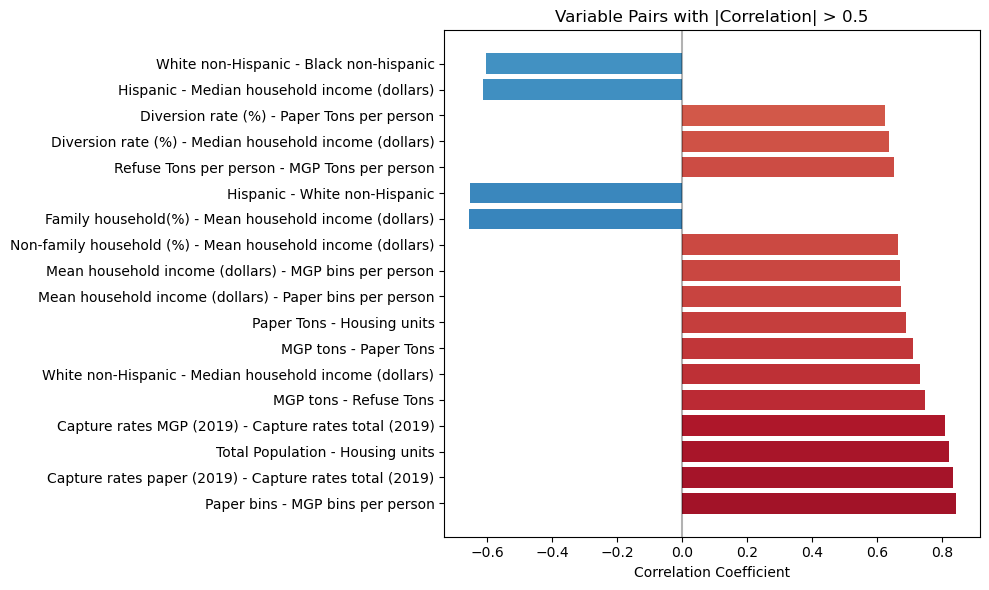

In [26]:
if not high_corr_pairs_cleaned.empty:
    plt.figure(figsize=(10, 6))
    
    # Create a bar plot of correlations
    plt.barh(
        [f"{row['Variable1']} - {row['Variable2']}" for _, row in high_corr_pairs_cleaned.iterrows()],
        high_corr_pairs_cleaned['Correlation'],
        color=[plt.cm.RdBu_r(0.5 * (1 + corr)) for corr in high_corr_pairs_cleaned['Correlation']]
    )
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Variable Pairs with |Correlation| > 0.5')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

We learn that diversion rate is positively correlated with income and paper tons per person. We also see that income is associated with the number of bins per person in the neighbourhood. Income is also associated with the fraction of white populaiton in the neighbourhood and is inversely proportional with hispanic populaiton. CDTAs with higher family households are inversely associated with median household income. 

These show that there is high non linearity between the data. Diversion rates are affected by parameters which in turn affect one another. 

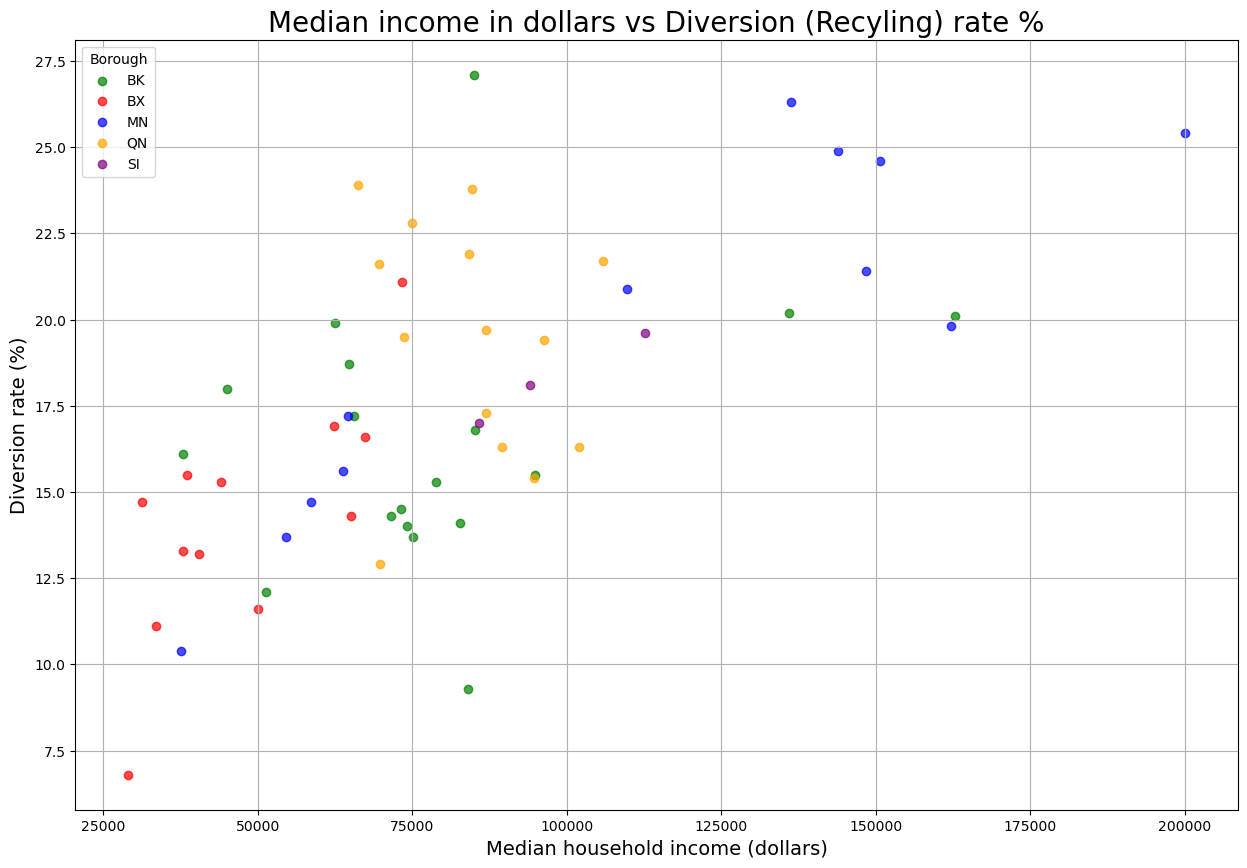

In [68]:
data_demo['Borough'] = data_demo['District'].str[:2]

# Define color mapping for each borough
color_map = {
    'MN': 'blue',   # Manhattan
    'BX': 'red',    # Bronx
    'BK': 'green',  # Brooklyn
    'QN': 'orange', # Queens
    'SI': 'purple'  # Staten Island
}

# Assign colors based on the borough
data_demo['Color'] = data_demo['Borough'].map(color_map)
x = data_demo["Median household income (dollars)"]
y = data_demo["Diversion rate (%)"]

# Linear fit
coefficients = np.polyfit(x, y, 1)  # 1st degree polynomial (linear)
poly = np.poly1d(coefficients)
y_fit = poly(x)

# Calculate error region (standard deviation of residuals)
error = np.std(y - y_fit)

# Sort the data for consistent shading
sorted_indices = np.argsort(x)
x_sorted = np.array(x)[sorted_indices]
y_fit_sorted = np.array(y_fit)[sorted_indices]

# Calculate R^2
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean) ** 2)
ss_residual = np.sum((y - y_fit) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the scatter plot with grouped borough colors
plt.figure(figsize=(15, 10))

# Scatter plot for each borough
for borough, group in data_demo.groupby('Borough'):
    plt.scatter(group["Median household income (dollars)"], 
                group["Diversion rate (%)"], 
                color=group["Color"].iloc[0], 
                label=borough, 
                alpha=0.7)

# Plot the fit line
#plt.plot(x_sorted, y_fit_sorted, color="blue", label="Fit Line")

# Fill the error region around the fit line
#plt.fill_between(x_sorted, y_fit_sorted - error, y_fit_sorted + error, color='blue', alpha=0.05, label="Error Region")

# Labels and Title
plt.xlabel("Median household income (dollars)", fontsize=14)
plt.ylabel("Diversion rate (%)", fontsize=14)
plt.title("Median income in dollars vs Diversion (Recyling) rate %", fontsize=20)
plt.grid(True)
plt.legend(title="Borough")

# Save and Show the plot
plt.savefig('Reg1_income_vs_diversion_by_borough_with_fit_and_error.png', bbox_inches='tight')
plt.show()

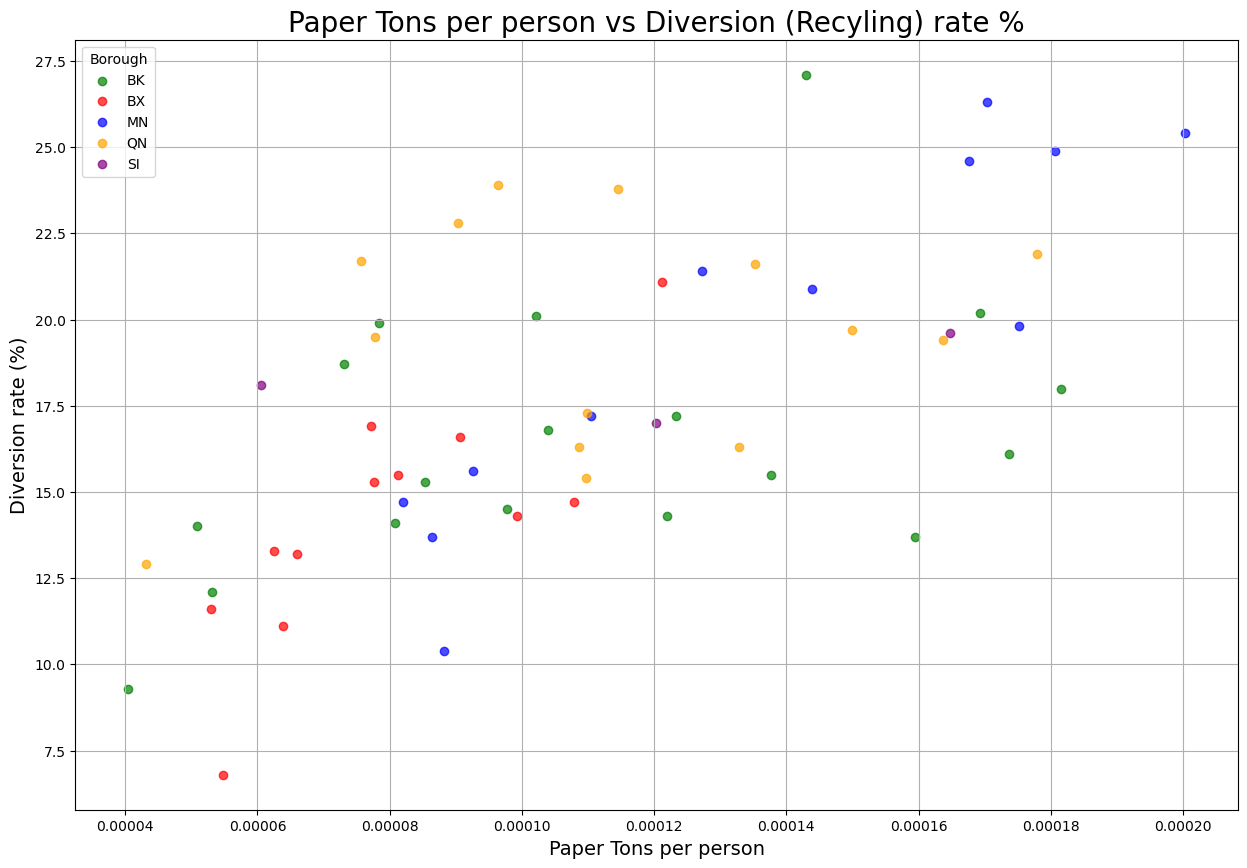

In [69]:
x = data_demo["Paper Tons per person"]
y = data_demo["Diversion rate (%)"]

# Plot the scatter plot with grouped borough colors
plt.figure(figsize=(15, 10))

# Scatter plot for each borough
for borough, group in data_demo.groupby('Borough'):
    plt.scatter(group["Paper Tons per person"], 
                group["Diversion rate (%)"], 
                color=group["Color"].iloc[0], 
                label=borough, 
                alpha=0.7)

# Labels and Title
plt.xlabel("Paper Tons per person", fontsize=14)
plt.ylabel("Diversion rate (%)", fontsize=14)
plt.title("Paper Tons per person vs Diversion (Recyling) rate %", fontsize=20)
plt.grid(True)
plt.legend(title="Borough")
plt.savefig('Reg2.png', bbox_inches='tight')
plt.show()

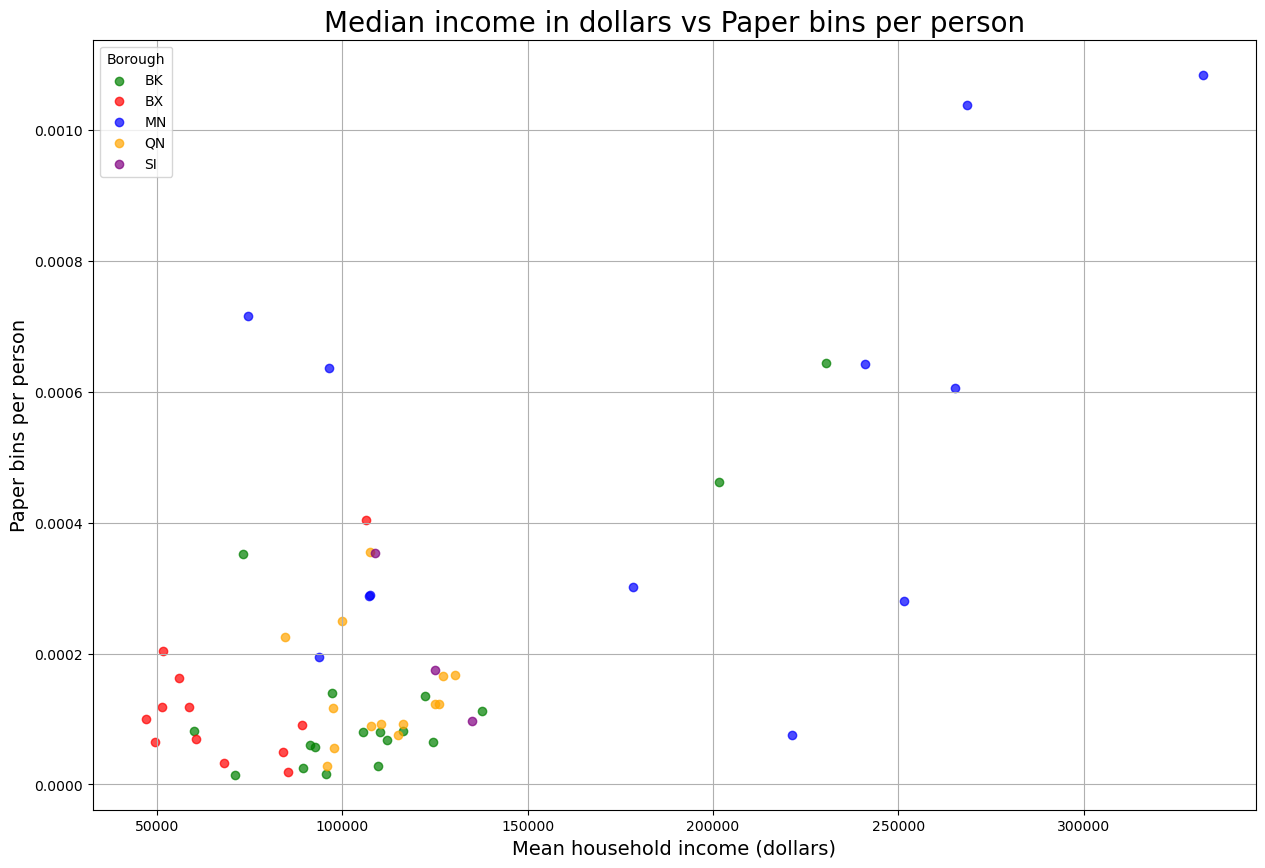

In [70]:
x = data_demo["Mean household income (dollars)"]
y = data_demo["Paper bins per person"]

# Plot the scatter plot with grouped borough colors
plt.figure(figsize=(15, 10))

# Scatter plot for each borough
for borough, group in data_demo.groupby('Borough'):
    plt.scatter(group["Mean household income (dollars)"], 
                group["Paper bins per person"], 
                color=group["Color"].iloc[0], 
                label=borough, 
                alpha=0.7)

# Labels and Title
plt.xlabel("Mean household income (dollars)", fontsize=14)
plt.ylabel("Paper bins per person", fontsize=14)
plt.title("Median income in dollars vs Paper bins per person", fontsize=20)
plt.grid(True)
plt.legend(title="Borough")
plt.savefig('Reg3.png', bbox_inches='tight')
plt.show()

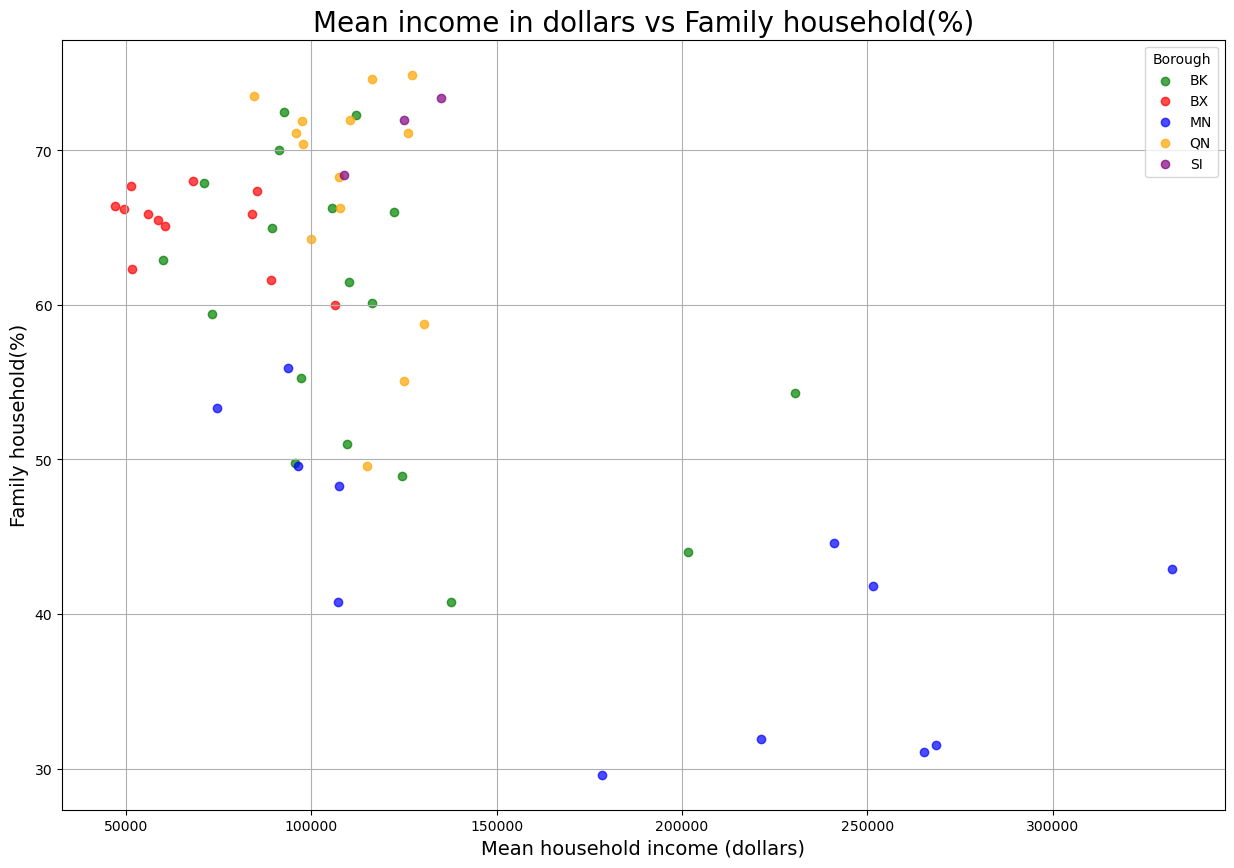

In [71]:
x = data_demo["Mean household income (dollars)"]
y = data_demo["Family household(%)"]

# Plot the scatter plot with grouped borough colors
plt.figure(figsize=(15, 10))

# Scatter plot for each borough
for borough, group in data_demo.groupby('Borough'):
    plt.scatter(group["Mean household income (dollars)"], 
                group["Family household(%)"], 
                color=group["Color"].iloc[0], 
                label=borough, 
                alpha=0.7)


# Labels and Title
plt.xlabel("Mean household income (dollars)", fontsize=14)
plt.ylabel("Family household(%)", fontsize=14)
plt.title("Mean income in dollars vs Family household(%)", fontsize=20)
plt.grid(True)
plt.legend(title="Borough")
plt.savefig('Reg4.png', bbox_inches='tight')

plt.show()

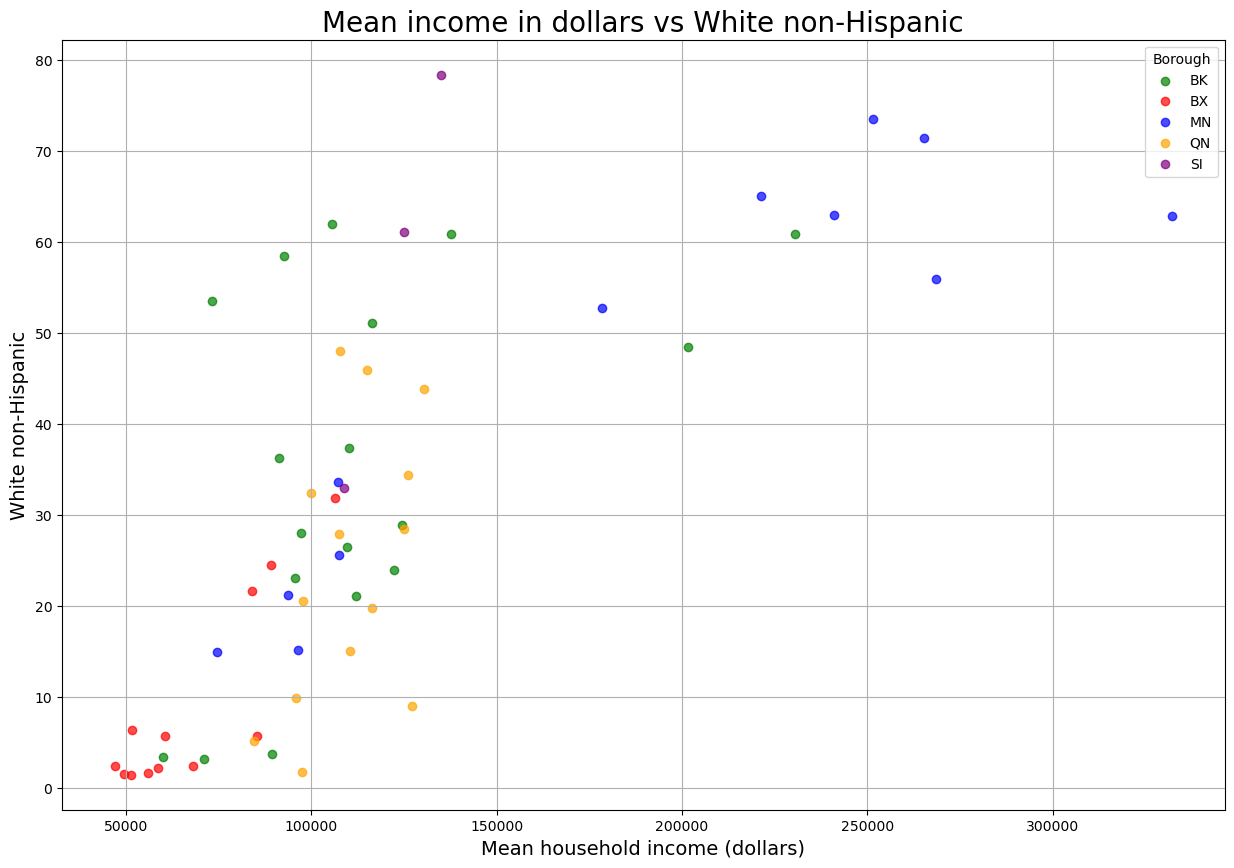

In [72]:
x = data_demo["Mean household income (dollars)"]
y = data_demo["White non-Hispanic"]

plt.figure(figsize=(15, 10))

# Scatter plot for each borough
for borough, group in data_demo.groupby('Borough'):
    plt.scatter(group["Mean household income (dollars)"], 
                group["White non-Hispanic"], 
                color=group["Color"].iloc[0], 
                label=borough, 
                alpha=0.7)


# Labels and Title
plt.xlabel("Mean household income (dollars)", fontsize=14)
plt.ylabel("White non-Hispanic", fontsize=14)
plt.title("Mean income in dollars vs White non-Hispanic", fontsize=20)
plt.grid(True)
plt.legend(title="Borough")
plt.savefig('Reg5.png', bbox_inches='tight')

plt.show()

We can combine these learnings into a multi variate regression model. While scatter plots allow us to pul out correlations, thety do not tell us how to quantify what we are seeing and to run statistics on how confident we are about the correlaitons we see. Regression allow us to put a number to how confident we are about one feature affecting the other. We will demonstrate this with OLS regression stats below. 


R²: 0.5336
RMSE: 2.9599


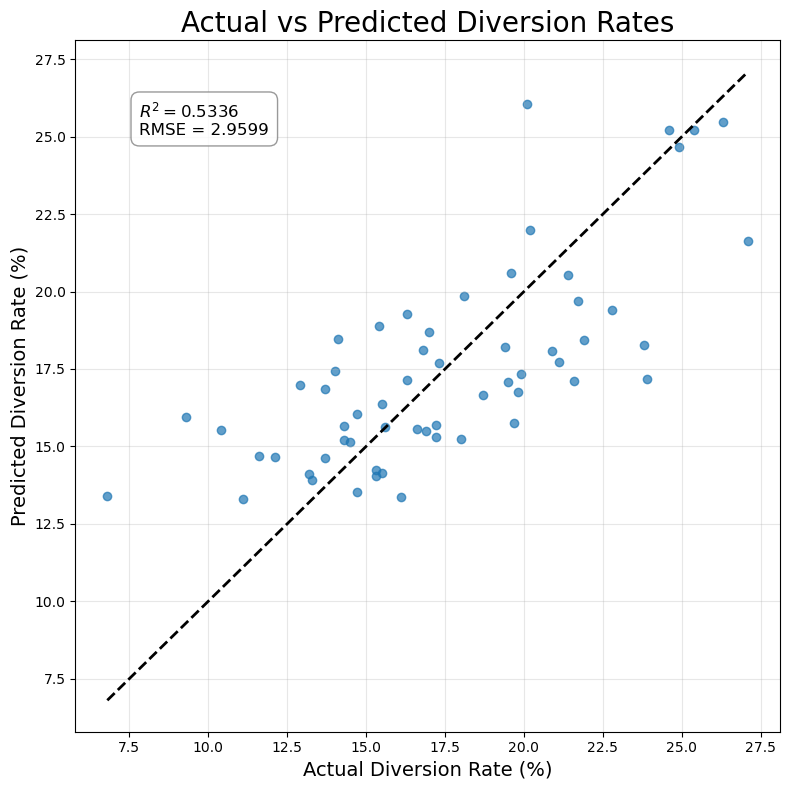

In [54]:
# Select multiple predictors
X_multi = data_demo[['Mean household income (dollars)', "Hispanic","Family household(%)",
              'White non-Hispanic', 'Housing units','Paper bins per person', 'MGP bins per person']]
y = data_demo['Diversion rate (%)']

# Fit model
lr_multi = LinearRegression()
lr_multi.fit(X_multi, y)
y_pred_multi = lr_multi.predict(X_multi)

# Calculate metrics
r2_multi = r2_score(y, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y, y_pred_multi))
print(f"\nR²: {r2_multi:.4f}")
print(f"RMSE: {rmse_multi:.4f}")

# Create a plot of actual vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred_multi, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Diversion Rate (%)', fontsize=14)
plt.ylabel('Predicted Diversion Rate (%)', fontsize=14)
plt.title('Actual vs Predicted Diversion Rates', fontsize=20)
plt.grid(True, alpha=0.3)

# Add R² and RMSE text inside the plot
# Position in the upper left corner with some padding
text_x = y.min() + (y.max() - y.min()) * 0.05  # 5% from the left edge
text_y = y.max() - (y.max() - y.min()) * 0.1   # 10% from the top edge

plt.text(text_x, text_y, 
         f'$R^2 = {r2_multi:.4f}$\nRMSE = {rmse_multi:.4f}', 
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.savefig("Lin_reg_.png")
plt.show()

In [63]:
def fit_and_summarize_OLS(X, y, model_name="Model"):
    # Add constant
    X_with_const = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(y, X_with_const).fit()
    
    # Print summary
    print(f"{model_name} Summary:")
    print(model.summary())
    
    return model

# Define your variables
X = data_demo[['Mean household income (dollars)', "Hispanic","Family household(%)",
              'White non-Hispanic', 'Housing units','Paper bins per person', 'MGP bins per person']]
y = data_demo['Diversion rate (%)']
fit_and_summarize_OLS(X, y, model_name="OLS")

OLS Summary:
                            OLS Regression Results                            
Dep. Variable:     Diversion rate (%)   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     8.335
Date:                Wed, 21 May 2025   Prob (F-statistic):           9.43e-07
Time:                        16:20:39   Log-Likelihood:                -147.74
No. Observations:                  59   AIC:                             311.5
Df Residuals:                      51   BIC:                             328.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

The model explains about 53.4% of the variation in diversion rates (R-squared: 0.534)
The overall model is statistically significant (F-statistic: 8.335, p-value: 9.43e-07)
Four variables have a statistically significant relationship with diversion rates:

Mean household income (positive effect, p<0.001)
Family household percentage (positive effect, p=0.006)
Paper bins per person (negative effect, p=0.005)
MGP (Metal Glass & Plastic) bins per person (positive effect, p=0.004)

1)Mean household income: For each additional dollar in mean household income, the diversion rate increases by about 0.00006621 percentage points. While this seems small, it means a $10,000 increase in income would be associated with about a 0.66 percentage point increase in diversion rate.

2)Family household percentage: A 1% increase in family households is associated with a 0.1335 percentage point increase in the diversion rate.

3)Paper bins per person: The negative coefficient (-584,500) suggests that more paper bins per person is associated with lower diversion rates. This seems counterintuitive but might indicate that areas with many paper bins have poor recycling practices or that the metric is capturing something else.

4)MGP bins per person: The positive coefficient (587,900) indicates that more mixed recycling bins per person is associated with higher diversion rates.

5)Non-significant variables: Hispanic percentage, White non-Hispanic percentage, and Housing units do not have statistically significant relationships with diversion rates in this model.


Multicollinearity warning: The condition number is very large (9.82e+10), indicating strong multicollinearity - some independent variables are highly correlated with each other. This can make the coefficients less reliable.
Normality of residuals: The Omnibus test (p=0.867) and Jarque-Bera test (p=0.825) suggest that the residuals are normally distributed, which is good.
Autocorrelation: The Durbin-Watson statistic (1.588) is somewhat close to 2, suggesting mild autocorrelation in the residuals.